In [11]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable


from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad

In [12]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)


In [128]:
K = 10
m = 3
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,1000)
Xs = np.r_[Xs1,np.linspace(0,10,10001)[1:]]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


In [147]:
a = 1/np.sqrt(Xs*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
omega_p = b*Xs


In [138]:
K = 10
m = 3
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,1000)
Xs = np.r_[Xs1,np.linspace(0,10,10001)[1:]]

R1_ls = []
R1_drs = []


for X in Xs:
    omega_p = X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R1_ls.append(R_l)
    R1_drs.append(R_dr)


In [ ]:
for X in zip(Xs):
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


In [152]:
a = 1/np.sqrt(Xs*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
omega_ps = b*Xs

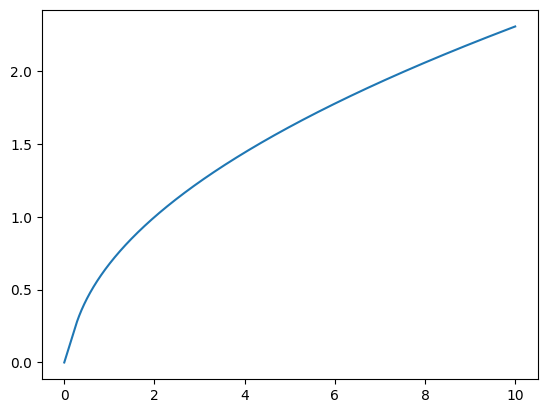

In [153]:
plt.plot(Xs,omega_ps)

In [ ]:
R1L = np.array(R1_ls)
R1D = 2*np.array(R1_drs)
K1K = 1/((R1L -R1D)/Xs)
K1_min_arg = np.argmin(K1K)
a = 1/np.sqrt(Xs*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
omega_ps = b*Xs

In [141]:
np.min(K1K)

1.8681312742636769

In [154]:
RL = np.array(R_ls)
RD = 2*np.array(R_drs)
KK = 1/((RL -RD)/Xs)
K_min_arg = np.argmin(KK)


Text(0, 0.5, '$F(X)=r$')

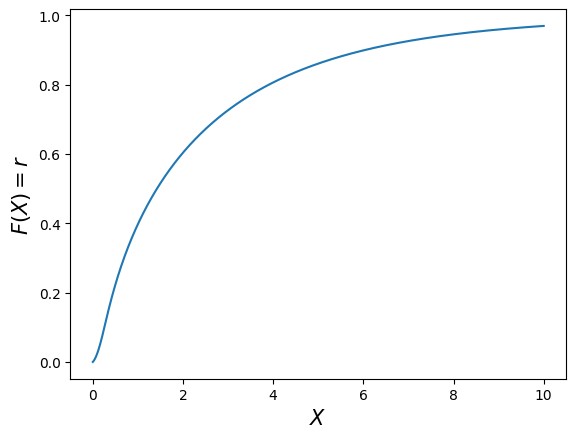

In [144]:
plt.plot(Xs,RL-RD)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)

Text(0, 0.5, '$G(X)=K$')

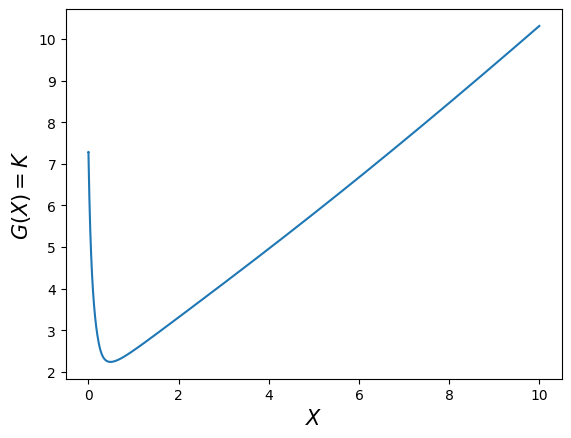

In [142]:
plt.plot(Xs,KK)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$G(X)=K$',fontsize=15)

In [131]:
K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = RL[:K_min_arg]
R_0u = RL[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

Text(0, 0.5, '$F(X)=r$')

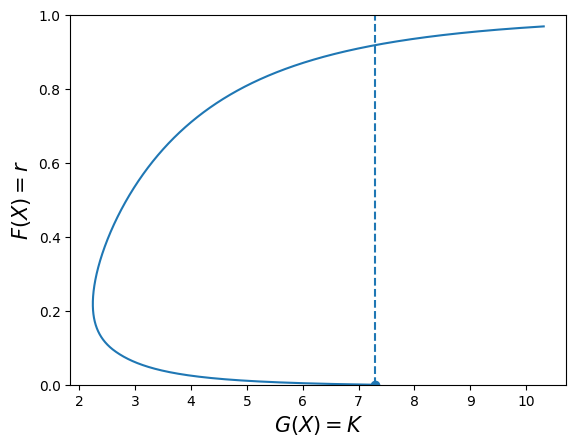

In [146]:
plt.plot(KK,Xs/KK)
# plt.plot(K1K,Xs/K1K)
plt.scatter(KK[0],Xs[0]/KK[0])
plt.axvline(KK[0],ls='--')
plt.ylim(0,1)
plt.xlabel(r'$G(X)=K$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)

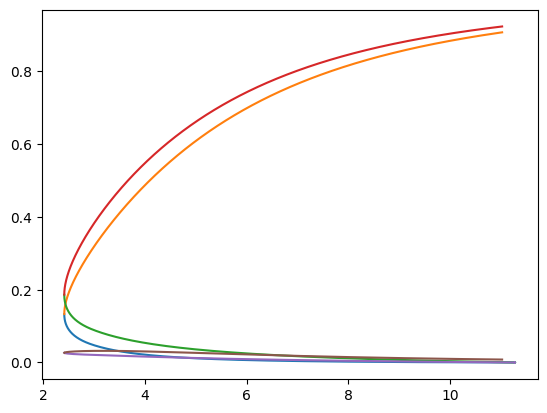

In [115]:
plt.plot(K_d,r_d)
plt.plot(K_u,r_u)
plt.plot(K_d,R_0d)
plt.plot(K_u,R_0u)


plt.plot(K_d,-R_dd/2)
plt.plot(K_u,-R_du/2)

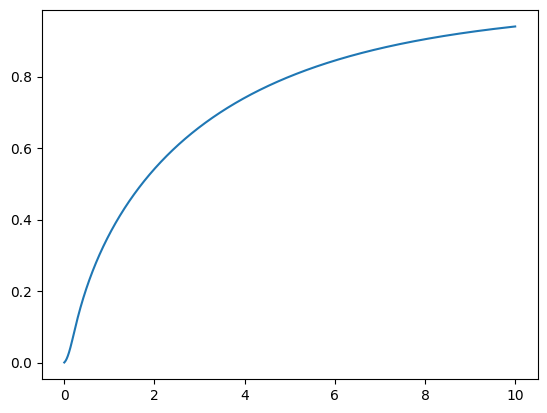

In [41]:
plt.plot(Xs,RL -RD)
# plt.ylim(-0.001,0.01)
# plt.xscale('log')
# plt.plot(rs,rs)